In [2]:
#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.figure as fgr
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

c:\Users\p059043\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


1. Introduction

Goal: Predict the best stock to invest in weekly using the Dow Jones Index data.

Task: Build a model that predicts which stock will perform best based on features from historical data.

### Data Loading

In [3]:
df = pd.read_csv("data/dow_jones_index.data", sep=',')
print(df.shape)
print(df.head(5))

(750, 16)
   quarter stock       date    open    high     low   close     volume  \
0        1    AA   1/7/2011  $15.82  $16.72  $15.78  $16.42  239655616   
1        1    AA  1/14/2011  $16.71  $16.71  $15.64  $15.97  242963398   
2        1    AA  1/21/2011  $16.19  $16.38  $15.60  $15.79  138428495   
3        1    AA  1/28/2011  $15.87  $16.63  $15.82  $16.13  151379173   
4        1    AA   2/4/2011  $16.18  $17.39  $16.18  $17.14  154387761   

   percent_change_price  percent_change_volume_over_last_wk  \
0               3.79267                                 NaN   
1              -4.42849                            1.380223   
2              -2.47066                          -43.024959   
3               1.63831                            9.355500   
4               5.93325                            1.987452   

   previous_weeks_volume next_weeks_open next_weeks_close  \
0                    NaN          $16.71           $15.97   
1            239655616.0          $16.19    

### Data Inspection

In [4]:
#Check data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   quarter                             750 non-null    int64  
 1   stock                               750 non-null    object 
 2   date                                750 non-null    object 
 3   open                                750 non-null    object 
 4   high                                750 non-null    object 
 5   low                                 750 non-null    object 
 6   close                               750 non-null    object 
 7   volume                              750 non-null    int64  
 8   percent_change_price                750 non-null    float64
 9   percent_change_volume_over_last_wk  720 non-null    float64
 10  previous_weeks_volume               720 non-null    float64
 11  next_weeks_open                     750 non-n

In [5]:
#Return number of missing values for each column
df.isna().sum()

quarter                                0
stock                                  0
date                                   0
open                                   0
high                                   0
low                                    0
close                                  0
volume                                 0
percent_change_price                   0
percent_change_volume_over_last_wk    30
previous_weeks_volume                 30
next_weeks_open                        0
next_weeks_close                       0
percent_change_next_weeks_price        0
days_to_next_dividend                  0
percent_return_next_dividend           0
dtype: int64

### Data Cleaning

In [10]:
#Convert stock to category and date to datetime
df['stock'] = df['stock'].astype('category')
df['date'] = pd.to_datetime(df['date'])

#Select all the remeining object columns (which are actually currency columns)
currency_features = df.select_dtypes(include=['object']).columns
#Remove the dollar sign from currency columns and convert to float
df[currency_features] = df[currency_features].replace('[\$,]', '', regex=True).astype(float)

#Check the types
print(df.dtypes)

quarter                                        int64
stock                                       category
date                                  datetime64[ns]
open                                         float64
high                                         float64
low                                          float64
close                                        float64
volume                                         int64
percent_change_price                         float64
percent_change_volume_over_last_wk           float64
previous_weeks_volume                        float64
next_weeks_open                              float64
next_weeks_close                             float64
percent_change_next_weeks_price              float64
days_to_next_dividend                          int64
percent_return_next_dividend                 float64
dtype: object


### Exploratory Data Analysis (EDA)

In [11]:
#Summary statistics for the dataset
df.describe().T.apply(lambda s: s.apply('{0:.3f}'.format))

count           mean            std  \
quarter                             750.000          1.520          0.500   
open                                750.000         53.652         32.639   
high                                750.000         54.670         33.216   
low                                 750.000         52.640         32.119   
close                               750.000         53.729         32.789   
volume                              750.000  117547801.407  158438089.361   
percent_change_price                750.000          0.050          2.518   
percent_change_volume_over_last_wk  720.000          5.594         40.543   
previous_weeks_volume               720.000  117387644.835  159232227.996   
next_weeks_open                     750.000         53.702         32.778   
next_weeks_close                    750.000         53.889         33.017   
percent_change_next_weeks_price     750.000          0.238          2.680   
days_to_next_dividend               750.000         52.525         46.335   
percent_return_next_dividend        750.000          0.692          0.305   

                                            min           25%           50%  \
quarter                                   1.000         1.000         2.000   
open                                     10.590        29.830        45.970   
high                                     10.940        30.627        46.885   
low                                      10.400        28.720        44.800   
close                                    10.520        30.365        45.930   
volume                              9718851.000  30866243.250  53060885.000   
percent_change_price                    -15.423        -1.288         0.000   
percent_change_volume_over_last_wk      -61.433       -19.804         0.513   
previous_weeks_volume               9718851.000  30678320.000  52945558.000   
next_weeks_open                          10.520        30.315        46.015   
next_weeks_close                         10.520        30.463        46.125   
percent_change_next_weeks_price         -15.423        -1.222         0.101   
days_to_next_dividend                     0.000        24.000        47.000   
percent_return_next_dividend              0.066         0.535         0.681   

                                              75%             max  
quarter                                     2.000           2.000  
open                                       72.715         172.110  
high                                       74.288         173.540  
low                                        71.037         167.820  
close                                      72.667         170.580  
volume                              132721823.750  1453438639.000  
percent_change_price                        1.651           9.882  
percent_change_volume_over_last_wk         21.801         327.409  
previous_weeks_volume               133322975.250  1453438639.000  
next_weeks_open                            72.715         172.110  
next_weeks_close                           72.915         174.540  
percent_change_next_weeks_price             1.846           9.882  
days_to_next_dividend                      69.000         336.000  
percent_return_next_dividend                0.854           1.564

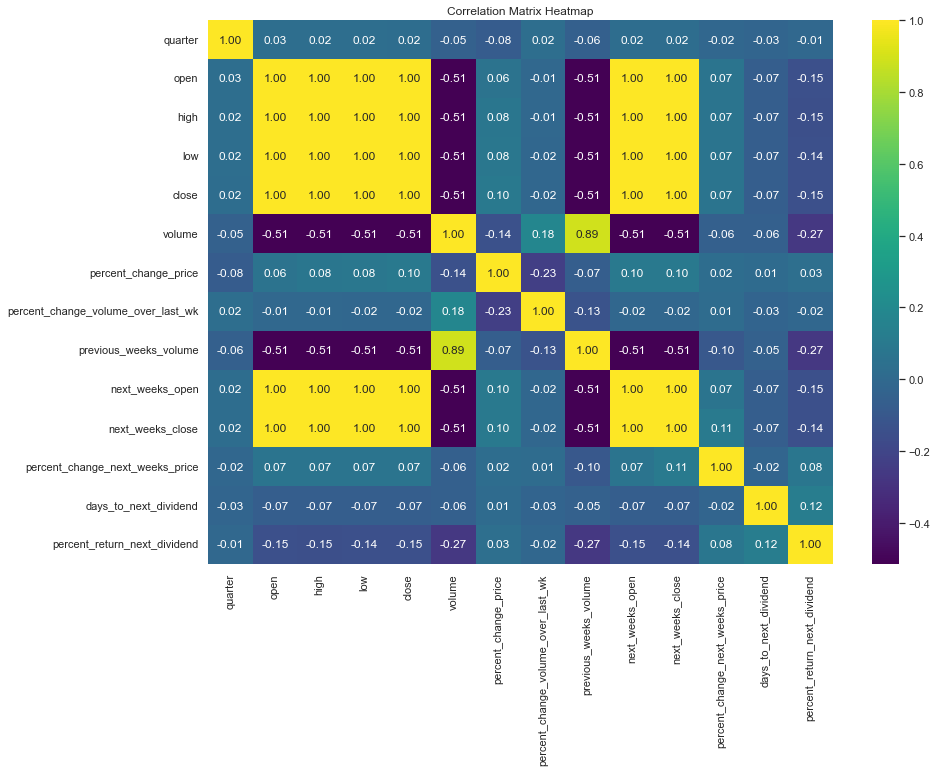

In [28]:
#Function to plot the correlation matrix heatmap of all numerical variables in data
def correlation_matrix(df):
    columns_of_interest = df.select_dtypes(include=[np.number]).columns
    df_selected = df[columns_of_interest]

    # Calculate the correlation matrix
    correlation_matrix = df_selected.corr(method = 'pearson')

    # Configure the size of the figure
    plt.figure(figsize=(14, 10))

    # Correlation heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f')
    plt.title('Correlation Matrix Heatmap')
    plt.show()

correlation_matrix(df)

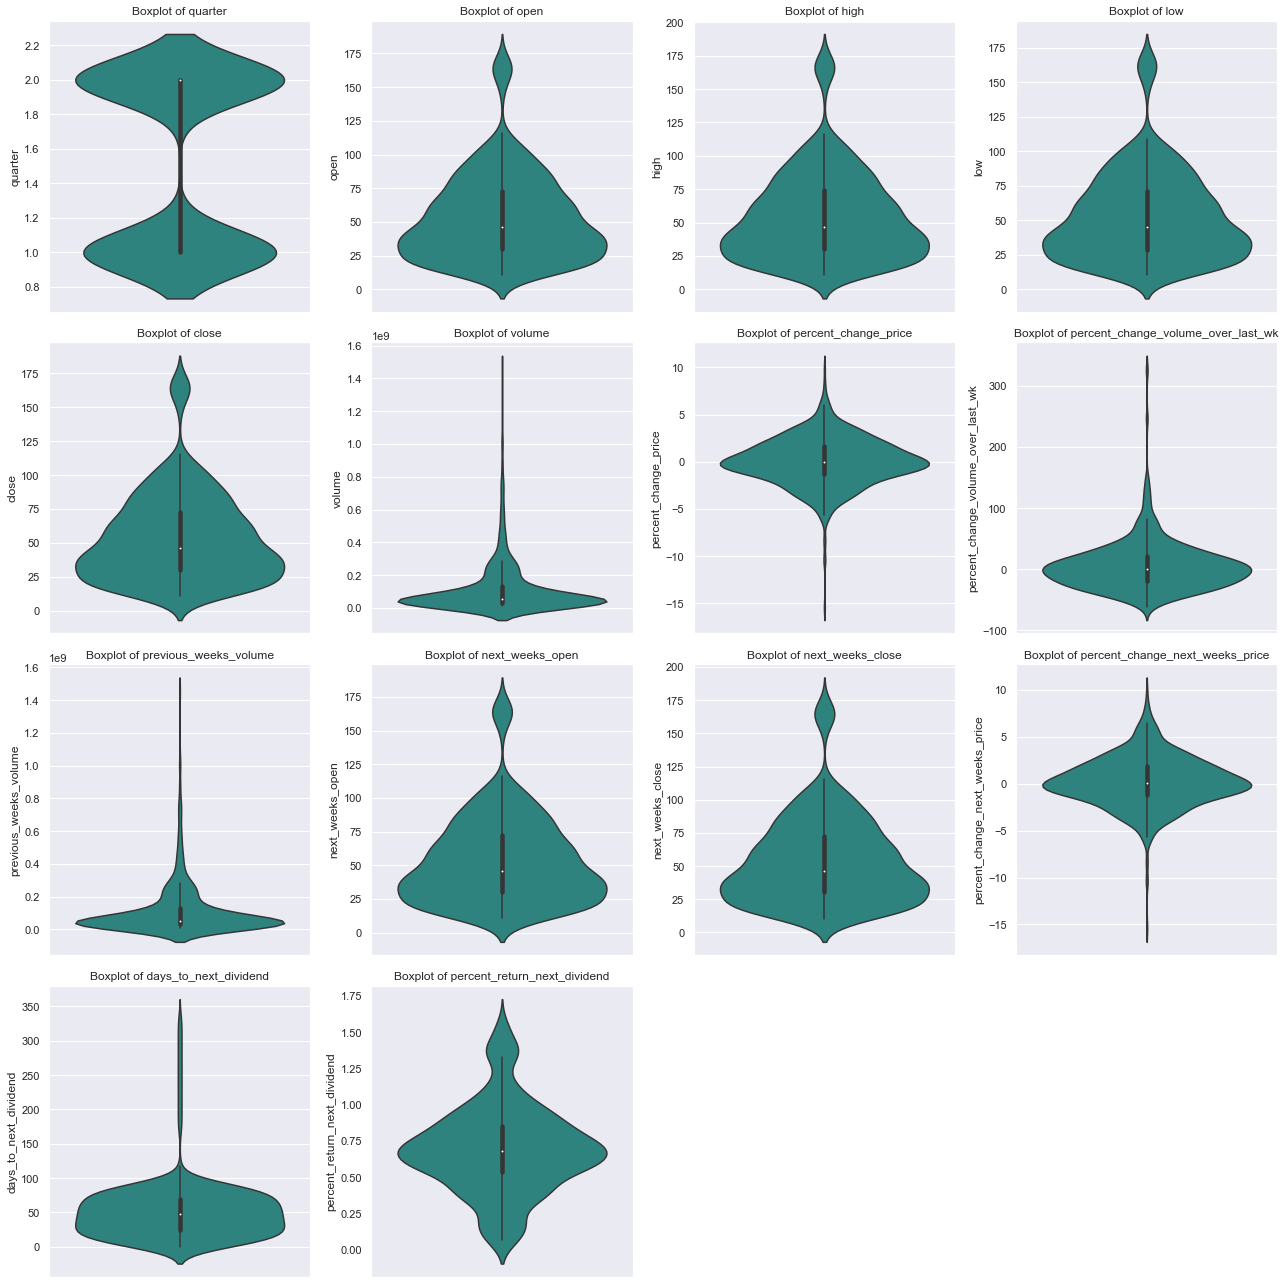

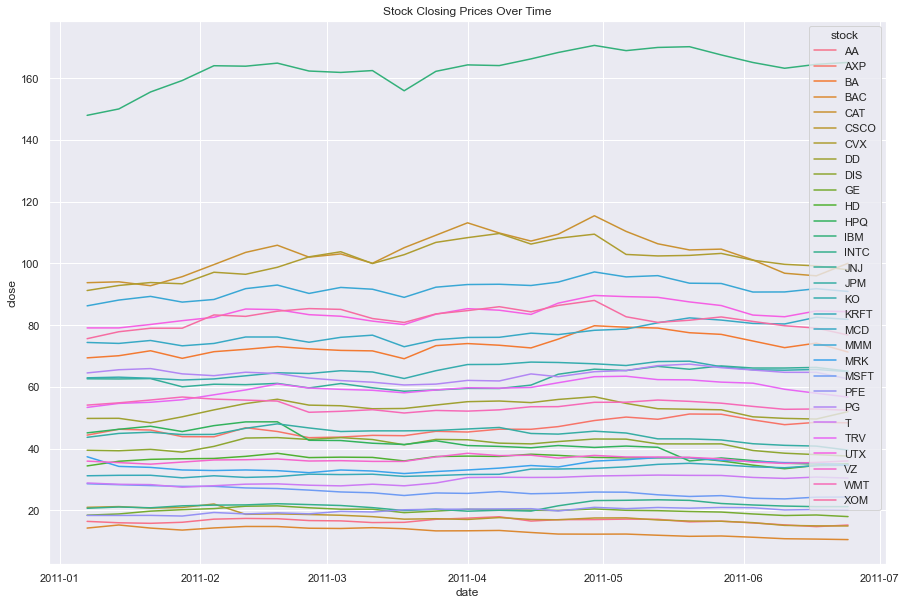

In [33]:
#Function to create violin plots of all numerical variables in data, checking distribution and density
def plot_violins(data):
    columns_of_interest = data.select_dtypes(include=[np.number]).columns
    plt.figure(figsize=(18, 18))

    # Loop to create boxplots for each numeric column
    for i, column in enumerate(columns_of_interest, 1):
        plt.subplot(4, 4, i)
        sns.violinplot(data=data, y=column, palette='viridis')
        plt.title(f'Boxplot of {column}')
        plt.ylabel(column)

    plt.tight_layout()
    plt.grid(False)
    plt.show()
    
plot_violins(df)

#Line plot of stock closing prices over time
def line_plot_feature(data, column):
    sns.set_theme(rc={'figure.figsize':(15, 10)})
    lineplot = sns.lineplot(data=data, x='date', y= column, hue='stock')
    plt.title('Stock Closing Prices Over Time')
    plt.show()

line_plot_feature(df, 'close')

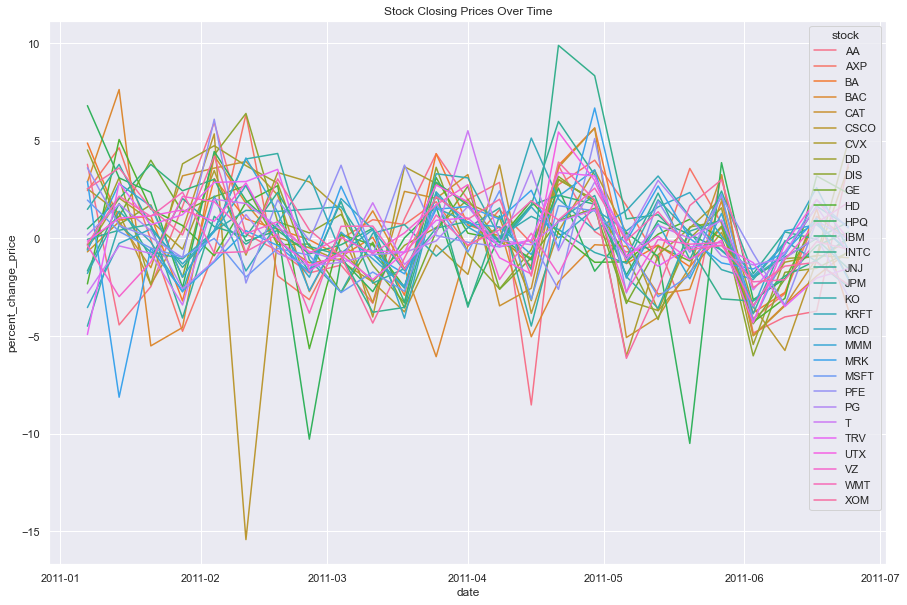

In [34]:
line_plot_feature(df, 'percent_change_price')

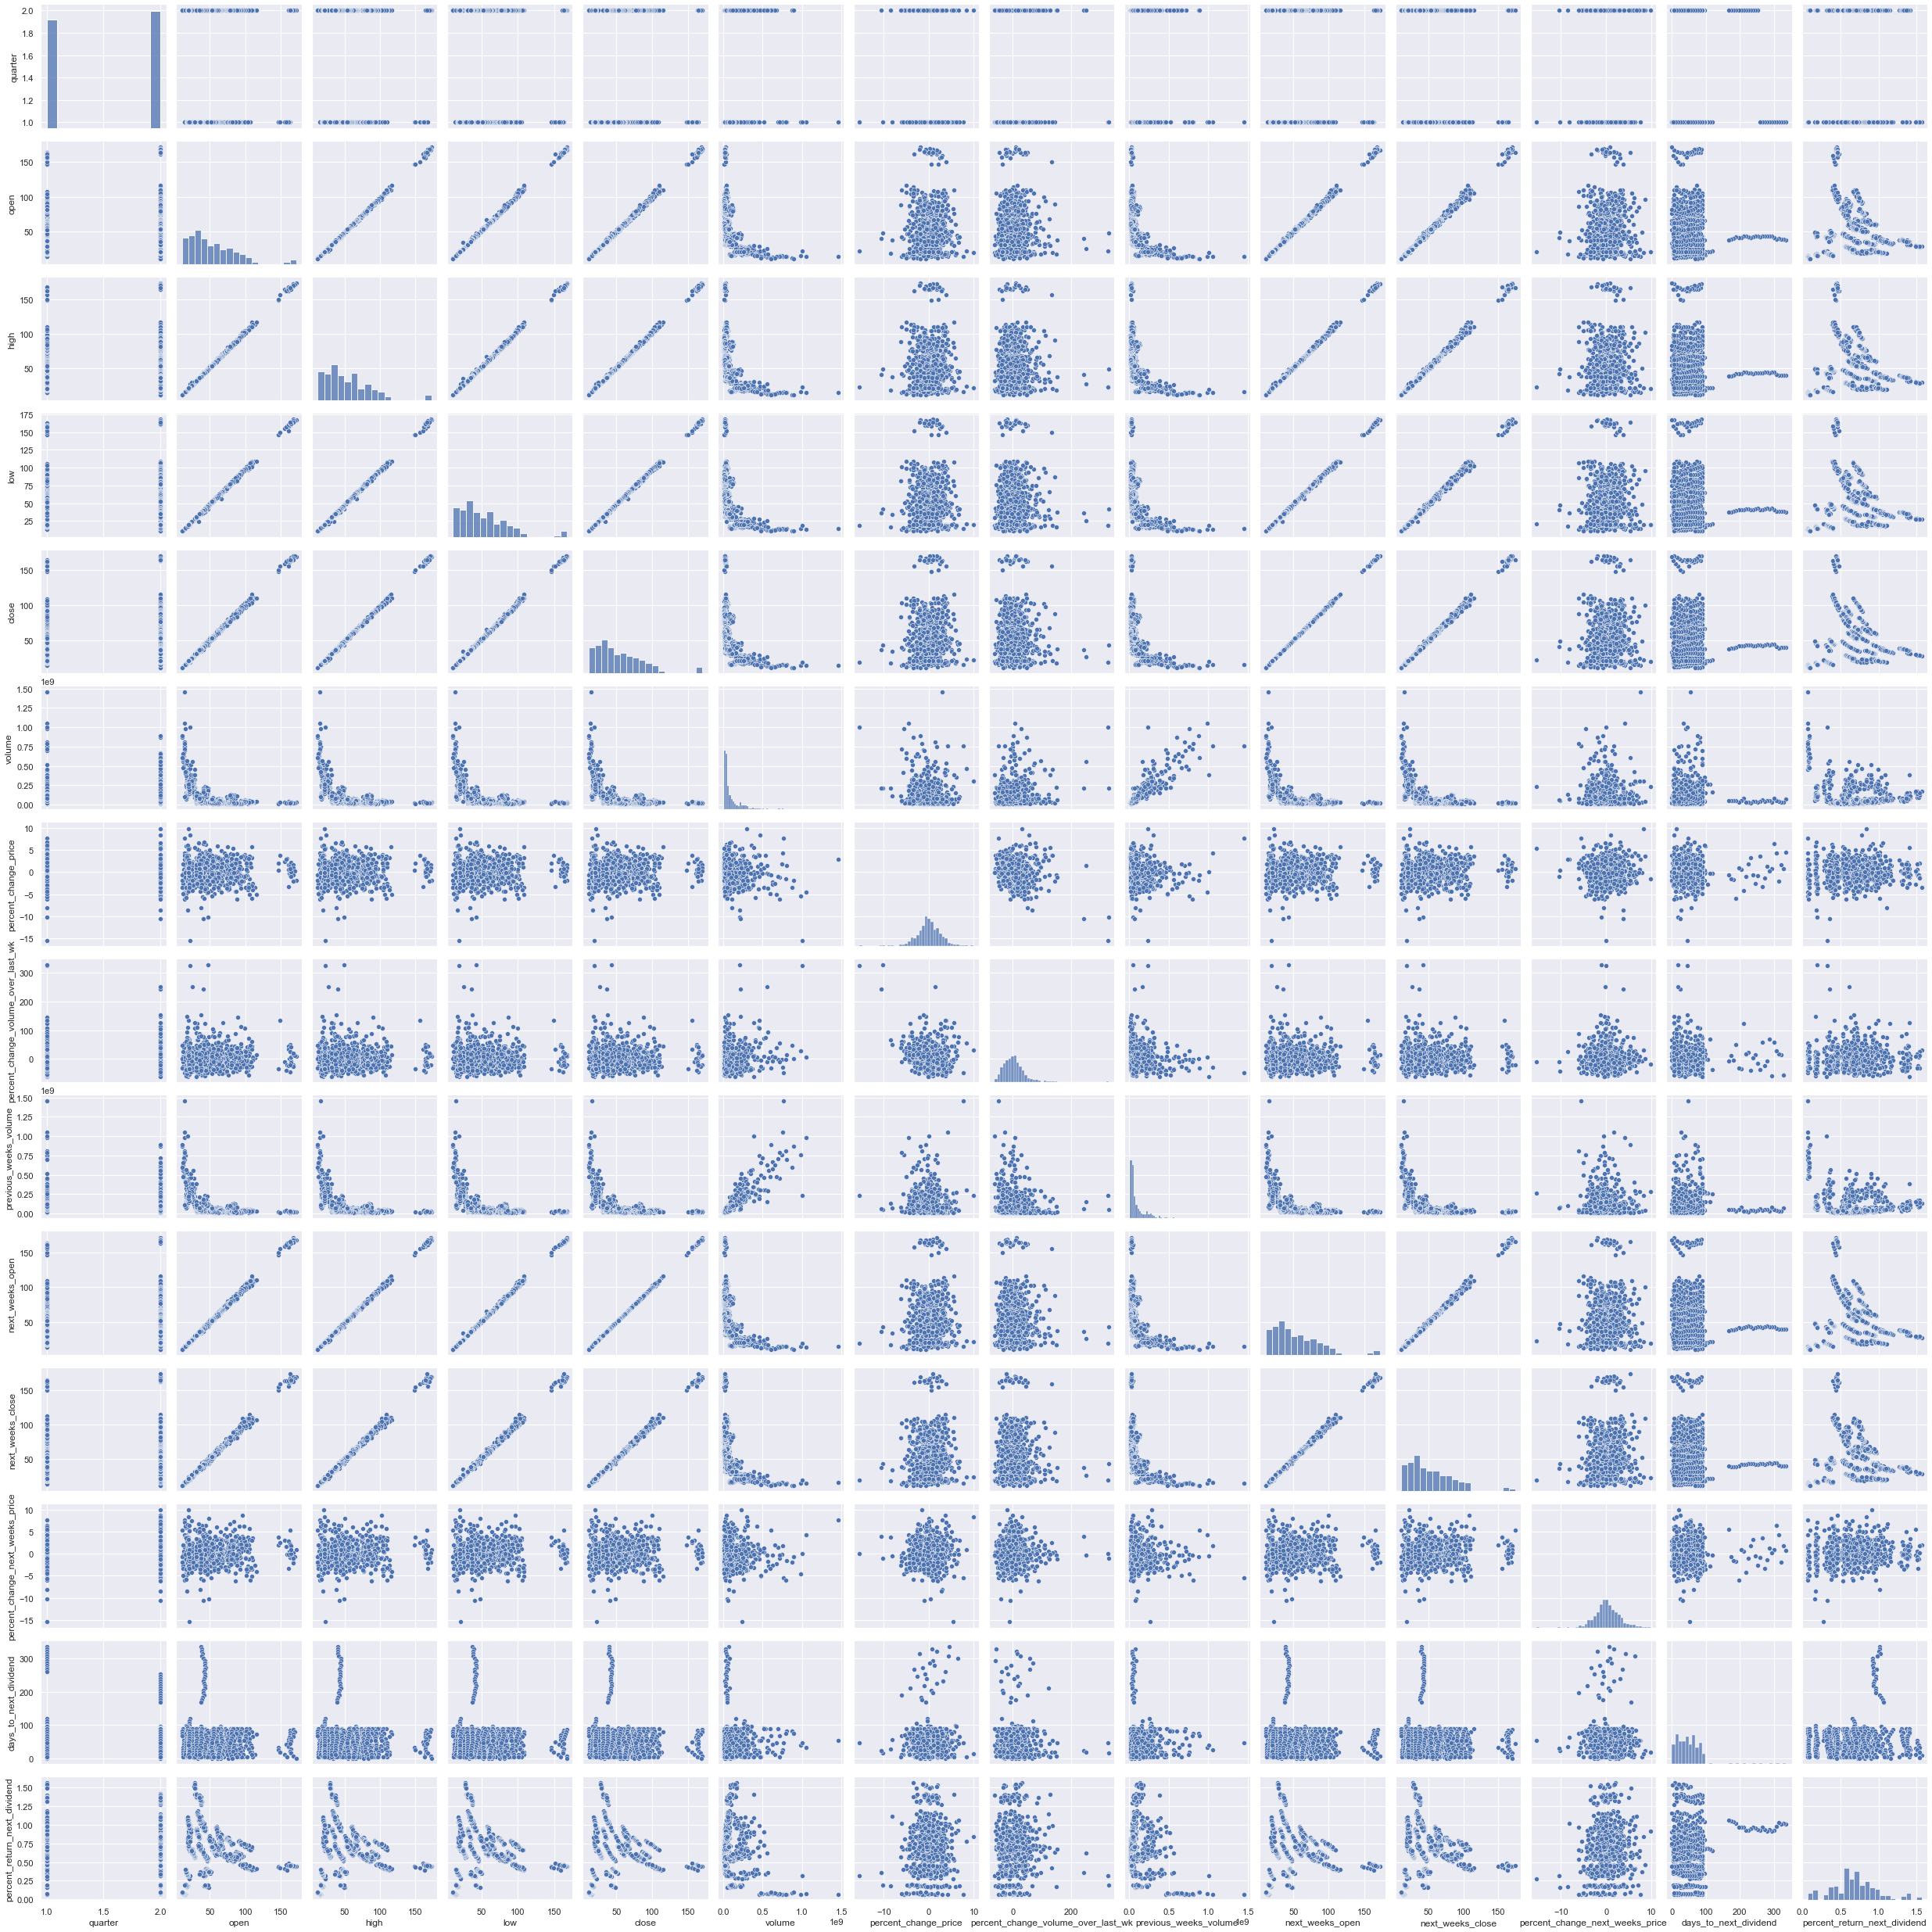

In [27]:
columns_of_interest = df.select_dtypes(include=[np.number]).columns
sns.pairplot(df[columns_of_interest])
plt.show()

<Figure size 1080x864 with 0 Axes>

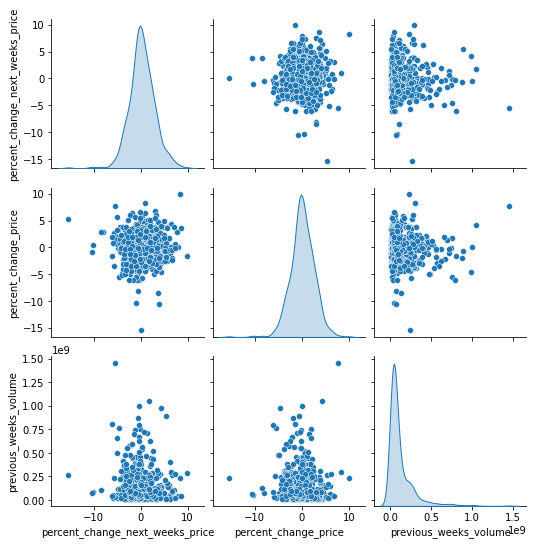

In [77]:
# Define the viridis colormap
viridis_palette = sns.color_palette("viridis", as_cmap=True)

# Set up the matplotlib figure
plt.figure(figsize=(15, 12))

# Create a pair plot with the viridis colormap
pair_plot = sns.pairplot(df[['percent_change_next_weeks_price', 'percent_change_price', 'previous_weeks_volume']], 
                         diag_kind='kde', 
                         markers='o',
                         palette=viridis_palette)


Text(0, 0.5, 'Percent Change')

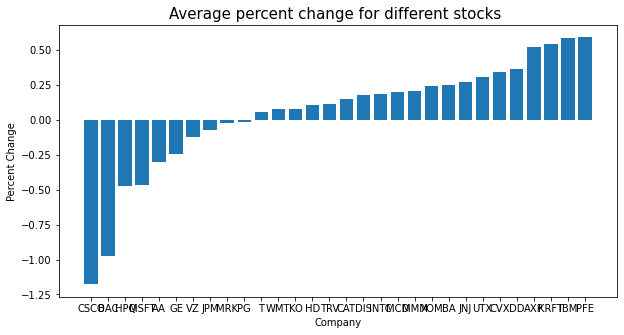

In [21]:
#Average Closing Price for different company through the years
Avg_change_pd = df.groupby('stock')['percent_change_price'].mean().to_frame()
Avg_change_pd.reset_index(level = 0, inplace = True)
Avg_change_pd = Avg_change_pd.sort_values('percent_change_price')

fig, ax = plt.subplots(figsize=(10, 5))

plt.bar(Avg_change_pd['stock'], Avg_change_pd['percent_change_price'])

plt.title("Average percent change for different stocks ",fontsize=15)
plt.xlabel("Company",fontsize=10)
plt.ylabel("Percent Change",fontsize=10)

### Feature Engineering

In [35]:
#Calculate volatility (high-low spread)
df['volatility'] = df['high'] - df['low']

#Rolling averages and volatility over 3 weeks
df['rolling_avg_3w'] = df.groupby('stock')['close'].rolling(window=3).mean().reset_index(0, drop=True)
df['rolling_vol_3w'] = df.groupby('stock')['volatility'].rolling(window=3).mean().reset_index(0, drop=True)

#df['ma_7'] = df.groupby('stock')['close'].rolling(window=7).mean().reset_index(0, drop=True)
#df['ma_3'] = df.groupby('stock')['close'].rolling(window=3).mean().reset_index(0, drop=True)

#Lag features of previous week's percent change
df['lag_1'] = df.groupby('stock')['percent_change_price'].shift(1)
df['lag_2'] = df.groupby('stock')['percent_change_price'].shift(2)

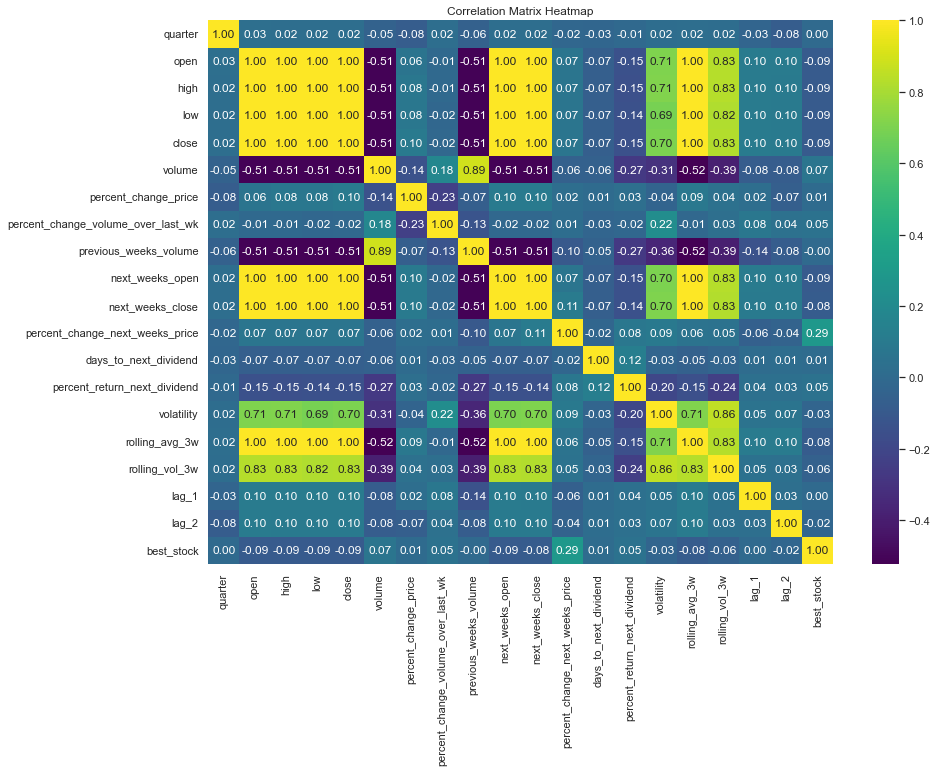

In [53]:
correlation_matrix(df)

## Modeling

In [36]:
#Create target column: 1 if it's the best-performing stock for that week, otherwise 0
df['best_stock'] = df.groupby('date')['percent_change_next_weeks_price'].transform(lambda x: (x == x.max()).astype(int))

### Xgboost

In [54]:
#Define features and target
features_with_date = ['date', 'stock', 'open', 'high', 'low', 'close', 'volume', 'percent_change_price', 
            'percent_change_volume_over_last_wk', 'previous_weeks_volume', 
            'days_to_next_dividend', 'percent_return_next_dividend', 'volatility', 'rolling_avg_3w', 'rolling_vol_3w', 'lag_1', 'lag_2']


features = ['open', 'high', 'low', 'close', 'volume', 'percent_change_price', 
            'percent_change_volume_over_last_wk', 'previous_weeks_volume', 
            'days_to_next_dividend', 'percent_return_next_dividend', 'volatility', 'rolling_avg_3w', 'rolling_vol_3w', 'lag_1', 'lag_2']

target = 'best_stock'

#Create a copy of dataframe and drop missing values
df_xgb = df.copy()
df_xgb = df_xgb.dropna()

X = df_xgb[features_with_date]
y = df_xgb[target]

# Train-test split - first 70% for training, last 20% for testing
train_size = int(len(df_xgb) * 0.7)
train_data = df_xgb.iloc[:train_size]
test_data = df_xgb.iloc[train_size:]

X_train = train_data[features_with_date]
y_train = train_data[target]
X_test = test_data[features_with_date]
y_test = test_data[target]

#smote = SMOTE(random_state=2)
#X_train_smote, y_train_smote = smote.fit_resample(X_train[features], y_train)

In [63]:
#Train XGBoost model
model = XGBClassifier(scale_pos_weight = 1.5, use_label_encoder=False)
model.fit(X_train[features], y_train)

#Evaluate performance
y_pred = model.predict(X_test[features])
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

[19:36:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       204
           1       0.00      0.00      0.00         4

    accuracy                           0.97       208
   macro avg       0.49      0.50      0.49       208
weighted avg       0.96      0.97      0.97       208



In [64]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [65]:
#Accuracy, precision, recall
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1:.2f}')

data_test = X_test.copy()  # Copy test data
data_test['predicted_best_stock'] = y_pred

#Merge with the original data to get the actual returns for each predicted stock
data_test = data_test.merge(df[['date', 'stock', 'percent_change_next_weeks_price']], on=['date','stock'], how='left')

#Assuming 100€ investment each week
data_test['predicted_return'] = data_test['percent_change_next_weeks_price']
cumulative_return = data_test[data_test['predicted_best_stock']==1]['predicted_return'].sum()
print(f'Cumulative Return: {cumulative_return} EUR')

Accuracy: 0.9711538461538461
Precision: 0.0
Recall: 0.0
F1 Score: 0.00
Cumulative Return: -2.7055936000000003 EUR


### Time Series Forecasting with LSTM

In [69]:
#Create a copy of dataframe then sort and drop missing values
df_lstm = df.copy()
df_lstm.set_index('date', inplace=True)
df_lstm.sort_index(axis=0,inplace=True)

features = ['close','volume','volatility','rolling_vol_3w','rolling_avg_3w','percent_change_price','previous_weeks_volume','percent_return_next_dividend','percent_change_next_weeks_price']
target = 'percent_change_next_weeks_price'

df_lstm = df_lstm[features]
df_lstm.fillna(0, inplace=True)

#Preprocessing for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_lstm)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length][:-1]) # Use seq_length data points as input (exclude the target)
        y.append(data[i+seq_length][-1]) #Target is 'percent_change_next_weeks_price' (the last column)
    return np.array(X), np.array(y)

seq_length = 4  #use the last 4 weeks to predict the next week
X, y = create_sequences(scaled_data, seq_length)

# Split into training and testing sets
train_size = int(0.7 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

#Define LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=120, batch_size=1, verbose=1)

# Make predictions
y_pred = model.predict(X_test)

Epoch 1/120
522/522 [==============================] - 11s 8ms/step - loss: 0.0209
Epoch 2/120
522/522 [==============================] - 4s 8ms/step - loss: 0.0117
Epoch 3/120
522/522 [==============================] - 4s 8ms/step - loss: 0.0113
Epoch 4/120
522/522 [==============================] - 4s 8ms/step - loss: 0.0108
Epoch 5/120
522/522 [==============================] - 4s 8ms/step - loss: 0.0108
Epoch 6/120
522/522 [==============================] - 4s 8ms/step - loss: 0.0107
Epoch 7/120
522/522 [==============================] - 4s 8ms/step - loss: 0.0105
Epoch 8/120
522/522 [==============================] - 4s 8ms/step - loss: 0.0104
Epoch 9/120
522/522 [==============================] - 4s 8ms/step - loss: 0.0108
Epoch 10/120
522/522 [==============================] - 6s 11ms/step - loss: 0.0103
Epoch 11/120
522/522 [==============================] - 5s 9ms/step - loss: 0.0104
Epoch 12/120
522/522 [==============================] - 4s 8ms/step - loss: 0.0105
Epoch 13/12

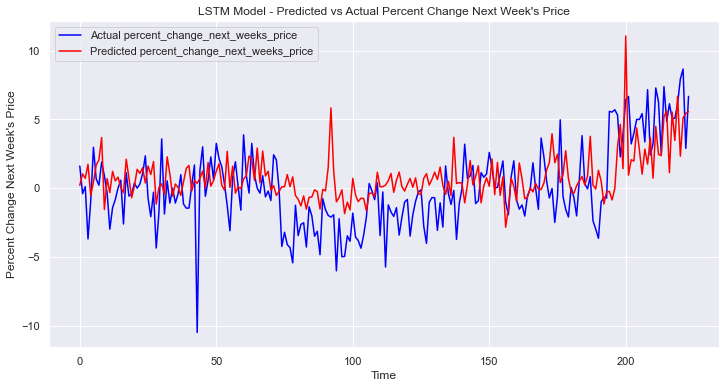

Root Mean Squared Error (MSE): 2.679293680168129


c:\Users\p059043\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [70]:
#Invert the scaling of the predicted data (back to original scale)
y_pred_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_pred), axis=1))[:, -1]
y_test_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]

#Plot the predicted vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, color='blue', label='Actual percent_change_next_weeks_price')
plt.plot(y_pred_rescaled, color='red', label='Predicted percent_change_next_weeks_price')
plt.title('LSTM Model - Predicted vs Actual Percent Change Next Week\'s Price')
plt.xlabel('Time')
plt.ylabel('Percent Change Next Week\'s Price')
plt.legend()
plt.show()

rmse = mean_squared_error(y_test_rescaled, y_pred_rescaled, squared=False)
print(f'Root Mean Squared Error (MSE): {rmse}')

In [75]:
def cumulative_returns(data):

    data['best_actual_stock'] = data.groupby('date')['percent_change_next_weeks_price'].transform(lambda x: (x == x.max()).astype(int))
    data['best_predicted_stock'] = data.groupby('date')['predicted_change_next_weeks_price'].transform(lambda x: (x == x.max()).astype(int))

    actual_returns_add = data[data['best_actual_stock']==1]['percent_change_next_weeks_price'].sum()
    predicted_returns_add = data[data['best_predicted_stock']==1]['percent_change_next_weeks_price'].sum()

    actual_returns_array = data[data['best_actual_stock']==1]['percent_change_next_weeks_price'].to_numpy()
    predicted_returns_array = data[data['best_predicted_stock']==1]['percent_change_next_weeks_price'].to_numpy()

    # Cumulative returns for both actual and predicted values (assuming initial investment of 100€)
    initial_investment = 100
    cumulative_actual_return = np.cumsum(actual_returns_array) * initial_investment / 100 + initial_investment
    cumulative_predicted_return = np.cumsum(predicted_returns_array) * initial_investment / 100 + initial_investment

    # Plot cumulative returns
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_actual_return, label='Actual Cumulative Return', color='blue')
    plt.plot(cumulative_predicted_return, label='Predicted Cumulative Return', color='red')
    plt.title('Cumulative Returns (Actual vs Predicted)')
    plt.xlabel('Weeks')
    plt.ylabel('Cumulative Return (€)')
    plt.legend()
    plt.show()

    # Step 7: Evaluate model with Mean Squared Error (MSE) as an additional metric
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(actual_returns_array, predicted_returns_array)
    print(f'Mean Squared Error (MSE): {mse}')
    rmse = root_mean_squared_error(actual_returns_array, predicted_returns_array)
    print(f'Root Mean Squared Error (RMSE): {rmse}')

    # Final cumulative returns
    final_actual_return = cumulative_actual_return[-1]
    final_predicted_return = cumulative_predicted_return[-1]

    print(f"Final Actual Cumulative Return: {final_actual_return:.2f} EUR")
    print(f"Final Predicted Cumulative Return: {final_predicted_return:.2f} EUR")
    print(f"Percentage of MAX returns acheived: {(100*predicted_returns_add)/actual_returns_add:.2f} %")

    print(cumulative_actual_return)
    print(cumulative_predicted_return)

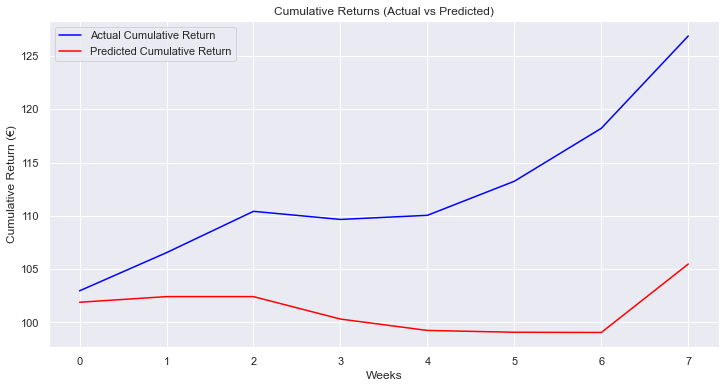

Mean Squared Error (MSE): 8.837293935680407
Root Mean Squared Error (RMSE): 2.97275864067038
Final Actual Cumulative Return: 126.89 EUR
Final Predicted Cumulative Return: 105.49 EUR
Percentage of MAX returns acheived: 20.41 %


In [76]:
df_lstm_test = df_lstm[train_size:]
df_lstm_test = df_lstm_test[seq_length:]

df_lstm_test['predicted_change_next_weeks_price'] = y_pred_rescaled

cumulative_returns(df_lstm_test)

### Time Series Forecasting with Prophet

14:11:06 - cmdstanpy - INFO - Chain [1] start processing
14:11:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\p059043\AppData\Local\Temp/ipykernel_5288/582991079.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_test['predicted_change_next_weeks_price'] = forecast['yhat_lower'].values
14:11:07 - cmdstanpy - INFO - Chain [1] start processing
14:11:07 - cmdstanpy - INFO - Chain [1] done processing
14:11:07 - cmdstanpy - INFO - Chain [1] start processing
14:11:07 - cmdstanpy - INFO - Chain [1] done processing
14:11:07 - cmdstanpy - INFO - Chain [1] start processing
14:11:07 - cmdstanpy - INFO - Chain [1] done processing
14:11:08 - cmdstanpy - INFO - Chain [1] start processing
14:11:08 - cmdstanpy - INFO - Chain [1] done processi

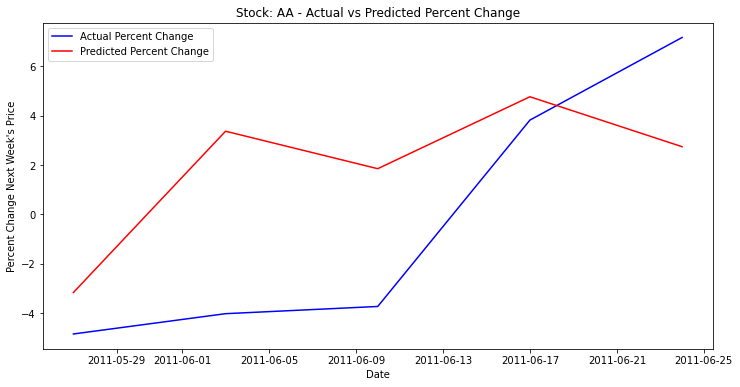

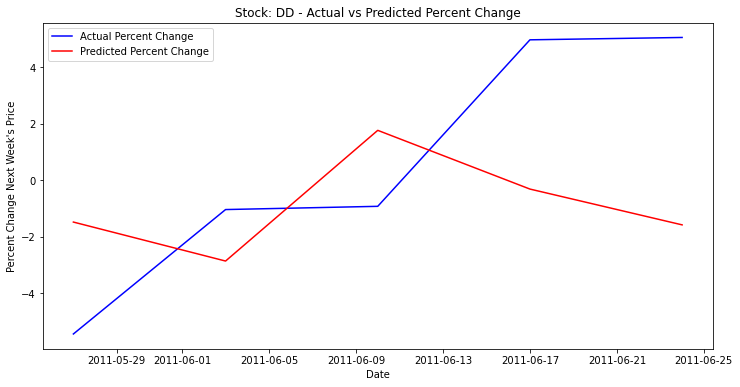

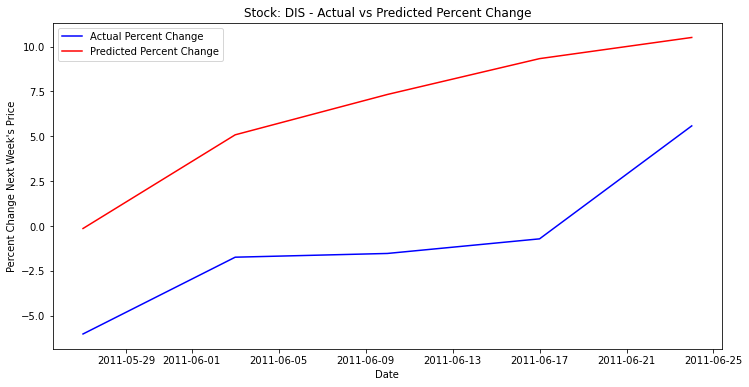

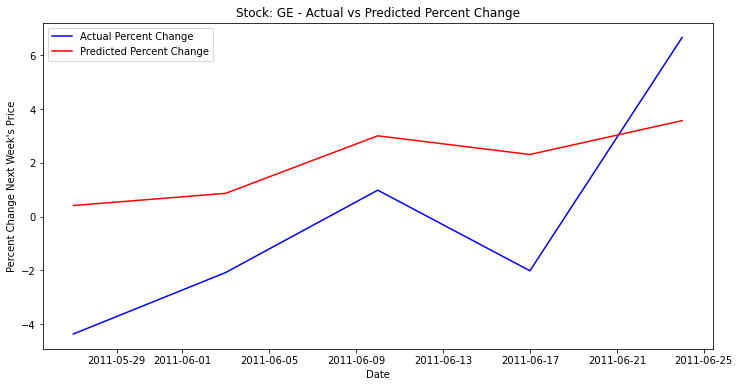

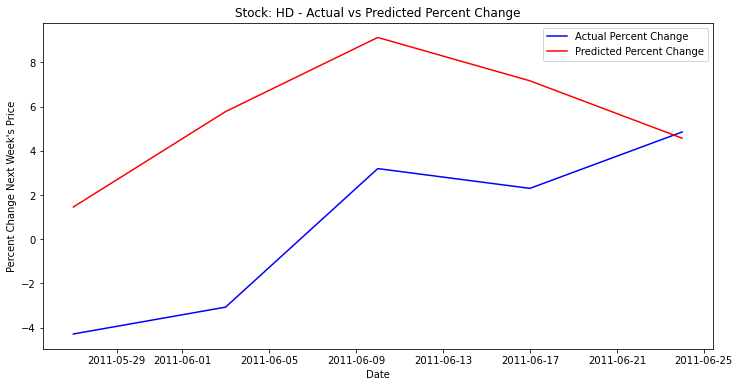

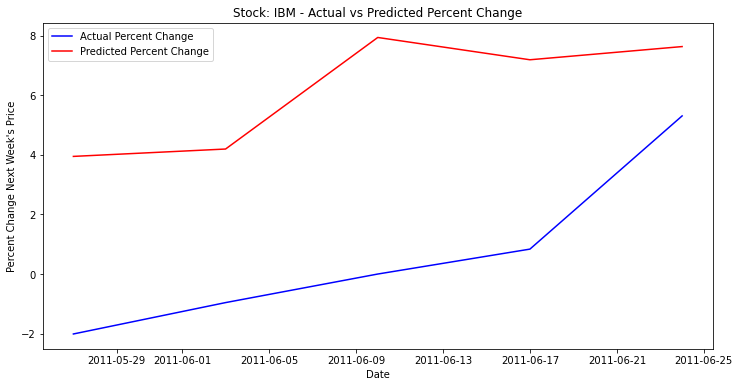

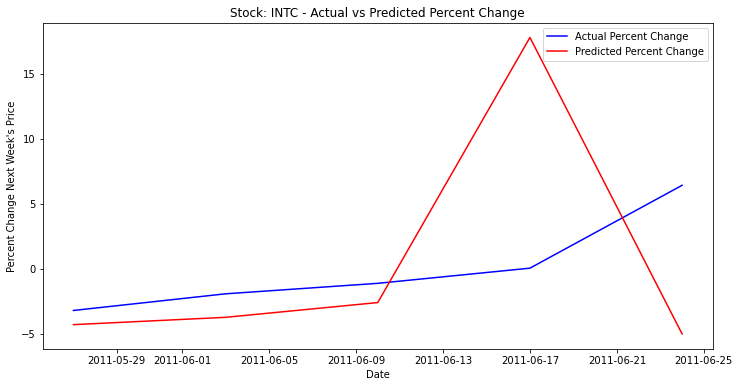

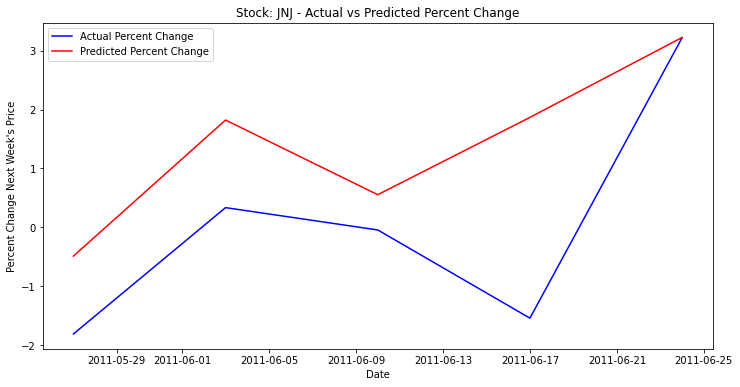

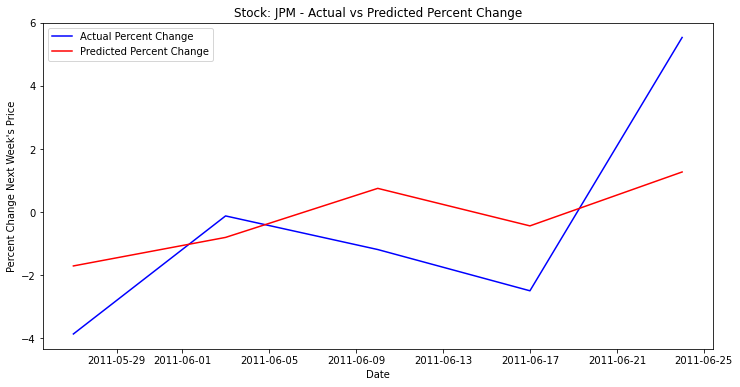

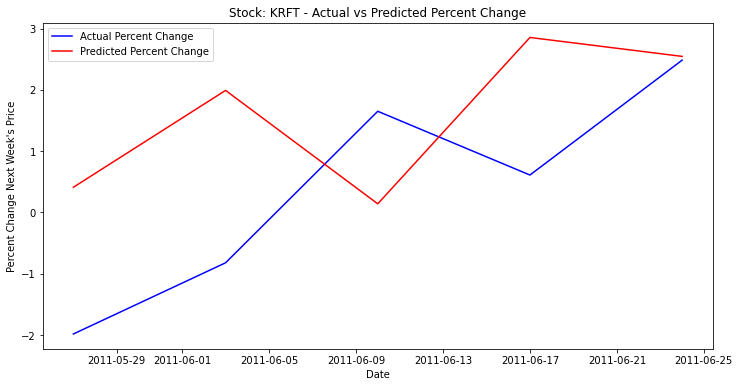

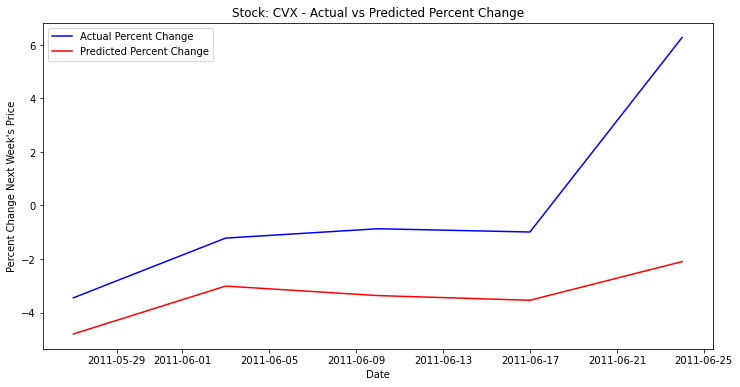

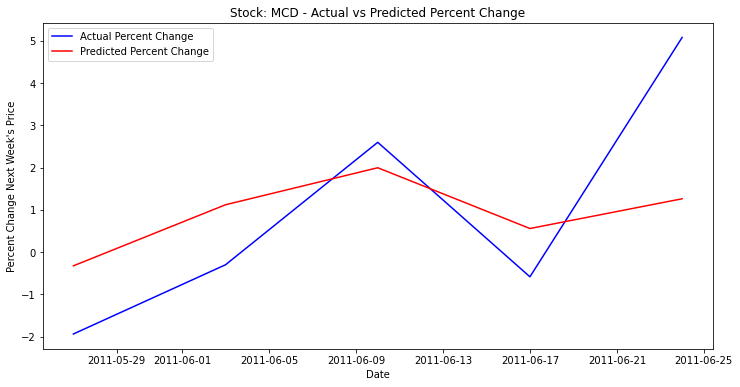

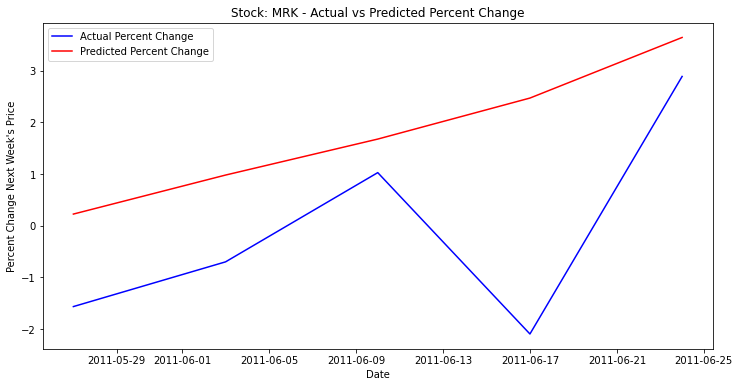

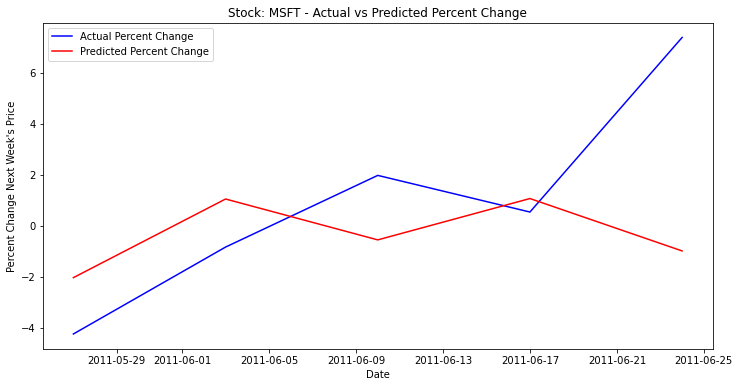

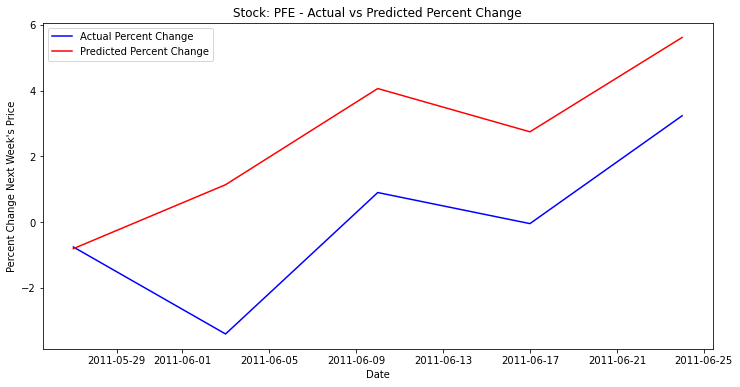

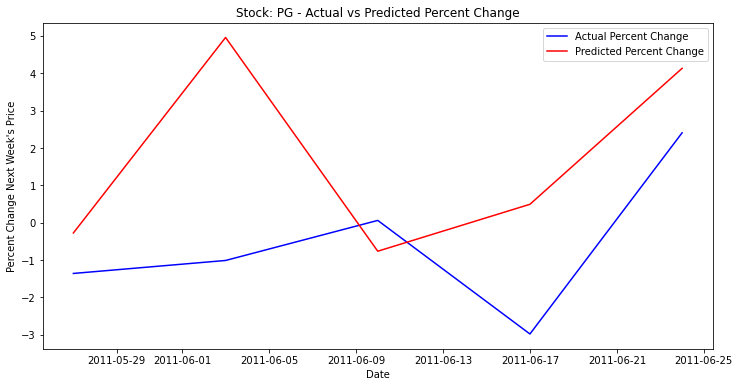

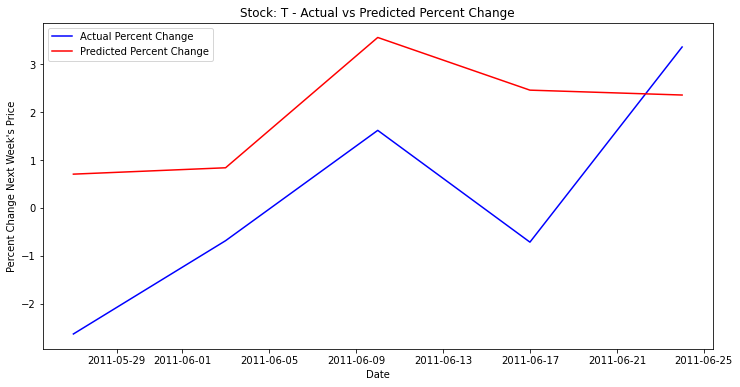

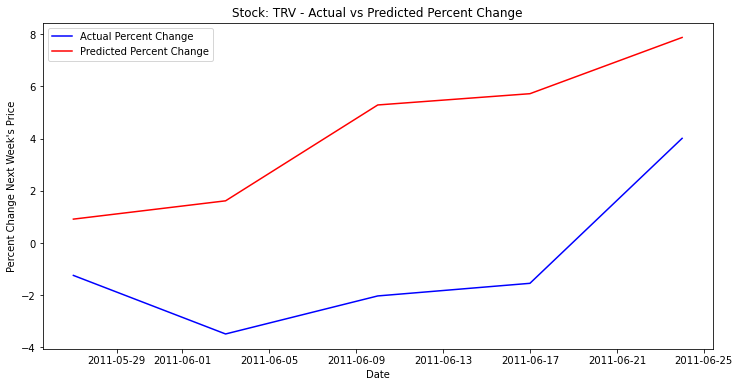

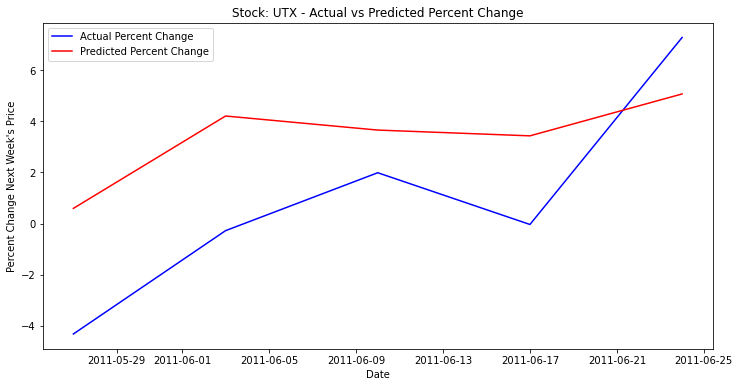

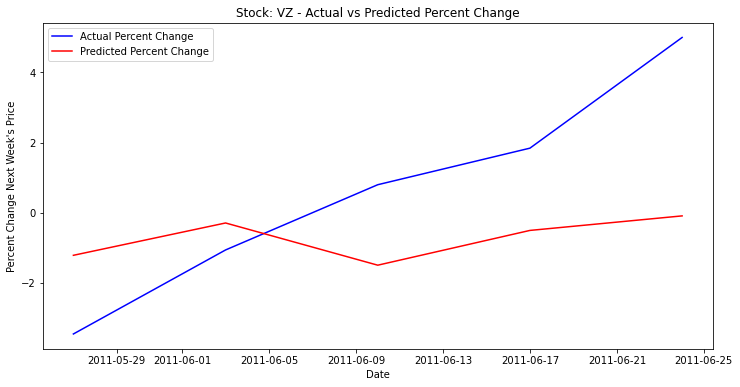

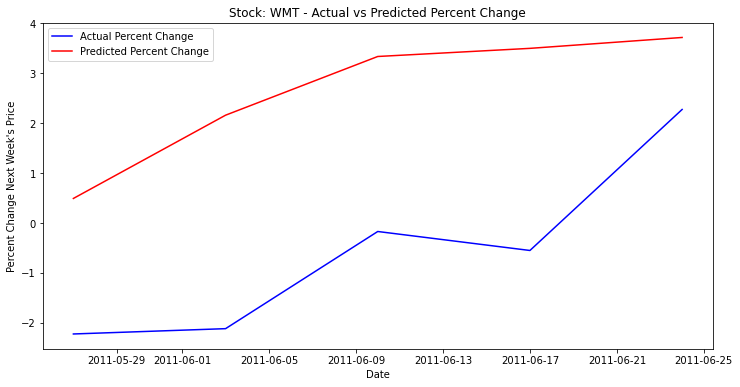

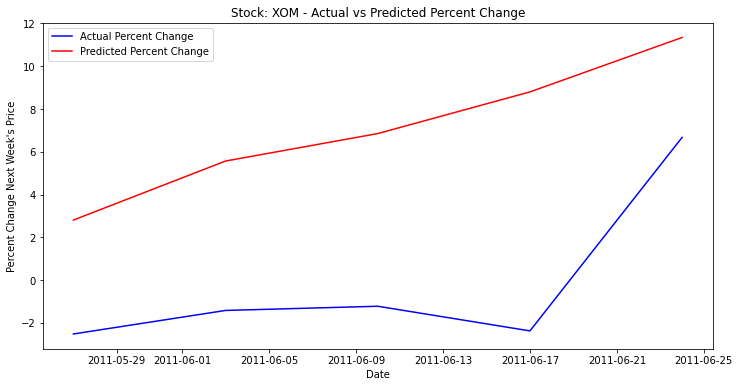

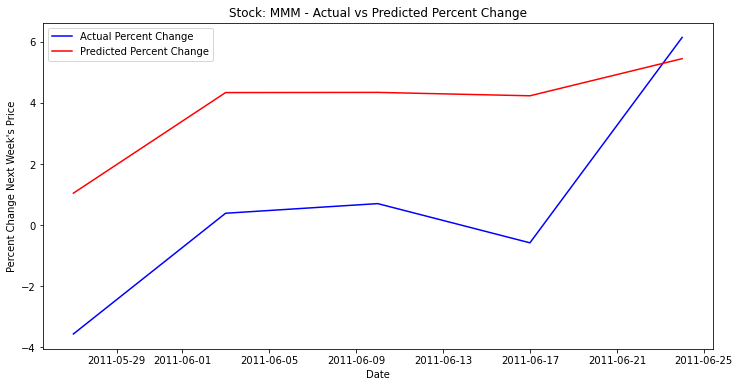

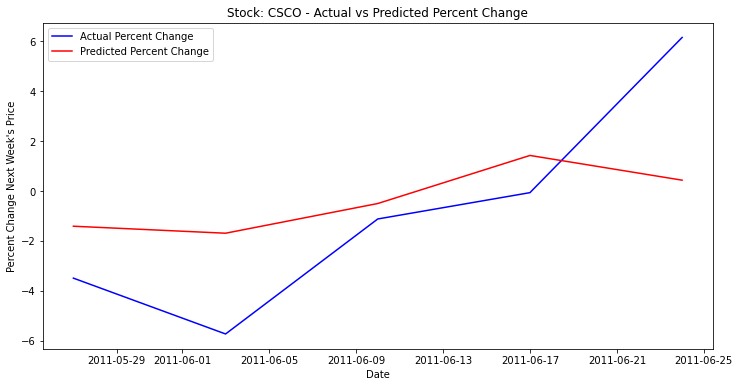

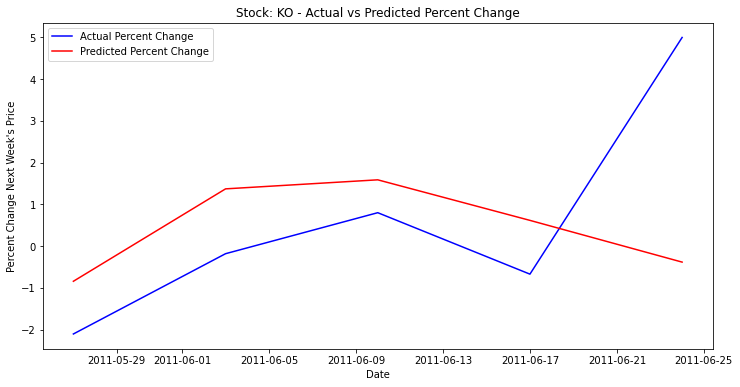

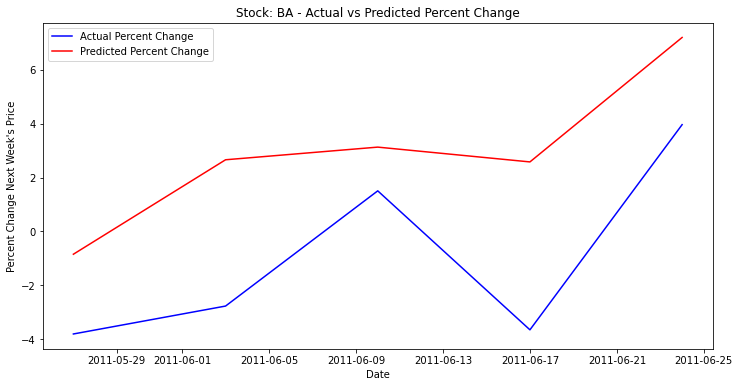

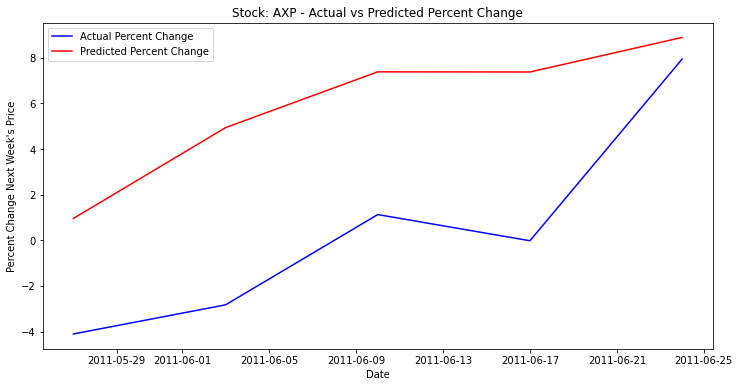

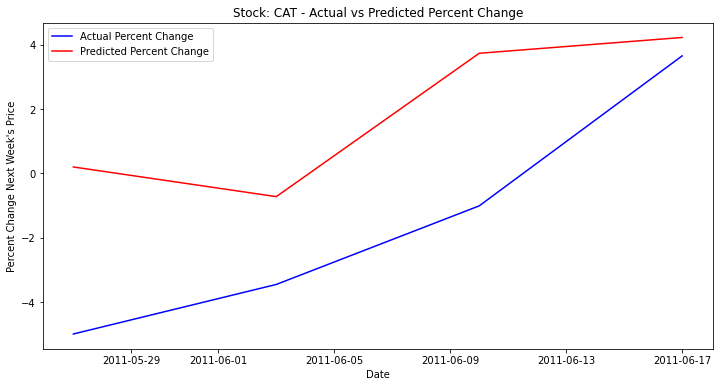

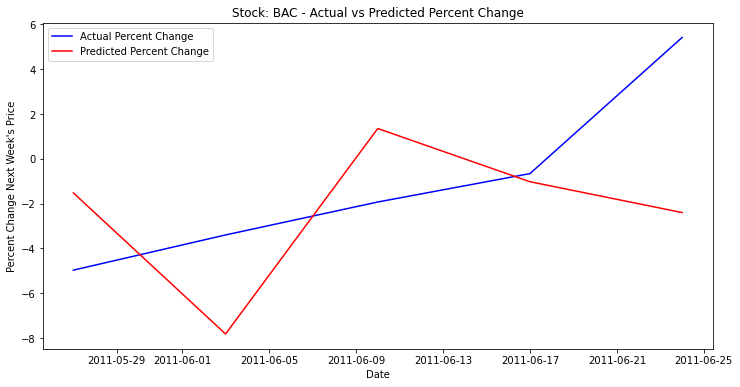

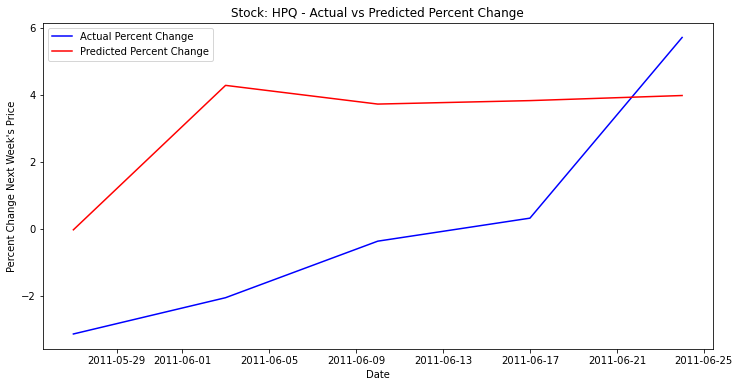

In [222]:
from prophet import Prophet

# Assuming 'data' contains the preprocessed data with 'date', 'stock', and 'percent_change_next_weeks_price'
df1 = df.copy()
df1= df1.dropna()
df1.sort_values(by=['date'], inplace=True)

# Remove extreme outliers based on the percent change
# For example, remove changes greater than 3 standard deviations from the mean
mean_change = df1['percent_change_next_weeks_price'].mean()
std_change = df1['percent_change_next_weeks_price'].std()

# Filter out extreme outliers
df1 = df1[(df1['percent_change_next_weeks_price'] > mean_change - 3 * std_change) &
            (df1['percent_change_next_weeks_price'] < mean_change + 3 * std_change)]

# Step 1: Split the dataset into training and testing (80% train, 20% test)
split_index = int(len(df1) * 0.7)

# Training data is the first 80% of the rows
train_data = df1.iloc[:split_index]

# Testing data is the last 20% of the rows
test_data = df1.iloc[split_index:]

split_date = pd.to_datetime('2011-05-21')

# Split the data into train and test sets
train_data = df1[df1.date < split_date]
test_data = df1[df1.date >= split_date]

# Step 2: Loop over each stock to fit a Prophet model and make predictions
predictions = pd.DataFrame()

for stock in df1['stock'].unique():
    #print(f"Running Prophet model for stock: {stock}")
    
    # Filter data for the current stock
    stock_train = train_data[train_data['stock'] == stock]
    
    stock_test = test_data[test_data['stock'] == stock]
    
    
    # Prepare the data for Prophet
    prophet_data = stock_train[['date', 'percent_change_next_weeks_price','close', 'volatility', 'rolling_avg_3w','lag_1']].copy()
    prophet_data.columns = ['ds', 'y', 'close', 'volatility', 'rolling_avg_3w','lag_1']# Prophet requires 'ds' for date and 'y' for target
    
    # Initialize and fit the Prophet model
    #Prophet has several hyperparameters that you can adjust, such as the seasonality mode and growth rate. By default, Prophet uses additive seasonality, but in financial data, it might be better to switch to multiplicative seasonality since stock returns tend to scale over time.
    model = Prophet(weekly_seasonality=True)
    model.add_regressor('close')
    model.add_regressor('volatility')
    model.add_regressor('rolling_avg_3w')
    model.add_regressor('lag_1')
    model.fit(prophet_data)
    
    # Create a future dataframe to predict for the test set
    future = pd.DataFrame(stock_test[['date', 'close', 'volatility', 'rolling_avg_3w','lag_1']])
    future.columns = ['ds', 'close', 'volatility', 'rolling_avg_3w','lag_1']
    # Make predictions
    forecast = model.predict(future)
   
    # Store the predictions with the stock information
    stock_test['predicted_change_next_weeks_price'] = forecast['yhat_lower'].values
    predictions = pd.concat([predictions, stock_test], axis=0)


# Step 3: Plot the actual vs predicted values for each stock in the test set
for stock in df1['stock'].unique():
    stock_predictions = predictions[predictions['stock'] == stock]
    
    plt.figure(figsize=(12, 6))
    plt.plot(stock_predictions['date'], stock_predictions['percent_change_next_weeks_price'], label='Actual Percent Change', color='blue')
    plt.plot(stock_predictions['date'], stock_predictions['predicted_change_next_weeks_price'], label='Predicted Percent Change', color='red')
    plt.title(f'Stock: {stock} - Actual vs Predicted Percent Change')
    plt.xlabel('Date')
    plt.ylabel('Percent Change Next Week\'s Price')
    plt.legend()
    plt.show()


In [228]:
cc=0
for stock in df1['stock'].unique():
    stock_predictions = predictions[predictions['stock'] == stock]
    mse = mean_squared_error(stock_predictions['percent_change_next_weeks_price'], stock_predictions['predicted_change_next_weeks_price'])
    cc= cc + mse
print(f"Mean Squared Error for stocks: {cc/df1['stock'].unique().shape[0]}")
print(mean_squared_error(stock_predictions['percent_change_next_weeks_price'], stock_predictions['predicted_change_next_weeks_price']))

rmse = root_mean_squared_error(stock_predictions['percent_change_next_weeks_price'], stock_predictions['predicted_change_next_weeks_price'])
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Squared Error for stocks: 20.408651552280563
16.356047169168356
Root Mean Squared Error (RMSE): 4.044261016448909


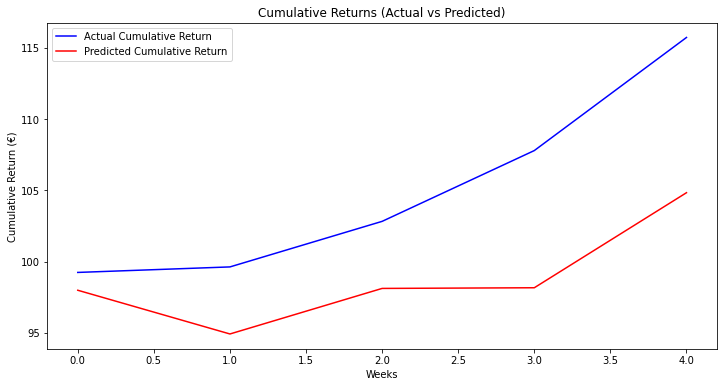

Mean Squared Error (MSE): 7.8703681148646805
Root Mean Squared Error (RMSE): 2.8054176364428667
Final Actual Cumulative Return: 115.73 EUR
Final Predicted Cumulative Return: 104.84 EUR
Percentage of MAX returns acheived: 30.73 %
[ 99.238095  99.625349 102.823199 107.792899 115.732679]
[ 97.98741    94.91762    98.11547    98.1626621 104.8354021]


c:\Users\p059043\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [229]:
predictions.sort_values(by=['date'], inplace=True)
cumulative_returns(predictions)

In [158]:
def cumulative_returns(data):

    data['best_actual_stock'] = data.groupby('date')['percent_change_next_weeks_price'].transform(lambda x: (x == x.max()).astype(int))
    data['best_predicted_stock'] = data.groupby('date')['predicted_change_next_weeks_price'].transform(lambda x: (x == x.max()).astype(int))

    actual_returns_add = data[data['best_actual_stock']==1]['percent_change_next_weeks_price'].sum()
    predicted_returns_add = data[data['best_predicted_stock']==1]['percent_change_next_weeks_price'].sum()

    actual_returns_array = data[data['best_actual_stock']==1]['percent_change_next_weeks_price'].to_numpy()
    predicted_returns_array = data[data['best_predicted_stock']==1]['percent_change_next_weeks_price'].to_numpy()

    # Cumulative returns for both actual and predicted values (assuming initial investment of 100€)
    initial_investment = 100
    cumulative_actual_return = np.cumsum(actual_returns_array) * initial_investment / 100 + initial_investment
    cumulative_predicted_return = np.cumsum(predicted_returns_array) * initial_investment / 100 + initial_investment

    # Plot cumulative returns
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_actual_return, label='Actual Cumulative Return', color='blue')
    plt.plot(cumulative_predicted_return, label='Predicted Cumulative Return', color='red')
    plt.title('Cumulative Returns (Actual vs Predicted)')
    plt.xlabel('Weeks')
    plt.ylabel('Cumulative Return (€)')
    plt.legend()
    plt.show()

    # Step 7: Evaluate model with Mean Squared Error (MSE) as an additional metric
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(actual_returns_array, predicted_returns_array)
    print(f'Mean Squared Error (MSE): {mse}')
    rmse = mean_squared_error(actual_returns_array, predicted_returns_array, squared=False)
    print(f'Root Mean Squared Error (RMSE): {rmse}')

    # Final cumulative returns
    final_actual_return = cumulative_actual_return[-1]
    final_predicted_return = cumulative_predicted_return[-1]

    print(f"Final Actual Cumulative Return: {final_actual_return:.2f} EUR")
    print(f"Final Predicted Cumulative Return: {final_predicted_return:.2f} EUR")
    print(f"Percentage of MAX returns acheived: {(100*predicted_returns_add)/actual_returns_add:.2f} %")

    print(cumulative_actual_return)

    print(cumulative_predicted_return)

In [58]:
from statsmodels.tsa.stattools import adfuller

# Check for stationarity using Augmented Dickey-Fuller Test (ADF Test)
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary; differencing is needed.")

# Check stationarity of 'percent_change_next_weeks_price'
adf_test(df['percent_change_next_weeks_price'])

AttributeError: module 'numpy' has no attribute 'MachAr'

In [ ]:
# Differencing the series to make it stationary
df['diff_percent_change'] = df['percent_change_next_weeks_price'].diff().dropna()

# Check stationarity after differencing
adf_test(df['diff_percent_change'])

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# Step 2: Fit the ARIMA model
# (p, d, q) parameters - you can experiment with different values
model = ARIMA(df['percent_change_next_weeks_price'], order=(5, 1, 0))  # AR(5), I(1), MA(0)
model_fit = model.fit(disp=0)

# Print model summary
print(model_fit.summary())

In [ ]:
# Step 3: Predict next 10 weeks
forecast, stderr, conf_int = model_fit.forecast(steps=10)

# Display the forecasted values
print(f"Forecasted Percent Change Next Week's Price: {forecast}")

In [ ]:
# Plot the actual vs forecasted percent change
plt.figure(figsize=(12, 6))
plt.plot(df['percent_change_next_weeks_price'][-50:], label="Actual Price Change", color='blue')
plt.plot(pd.date_range(df['date'].iloc[-1], periods=10, freq='W'), forecast, label="Forecasted Price Change", color='red')
plt.fill_between(pd.date_range(df['date'].iloc[-1], periods=10, freq='W'), conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('ARIMA Model - Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Percent Change Next Week\'s Price')
plt.show()